In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import json
import os
from bmtool.util.util import load_nodes_from_paths
from  scipy.ndimage import gaussian_filter

from analysis import plot, utils, process # imoporting analysis module enables import from model folder
from build_input import get_populations, input_pairs_from_file

%matplotlib inline

TRIAL_NAME = "ramp_a0_t1.0"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

### Load data

In [2]:
stimulus_type, config = utils.stimulus_type_from_trial_name(TRIAL_NAME)
isstandard = stimulus_type == 'short' or stimulus_type == 'long'  # do not apply for baseline case

pop_color = plot.pop_color
pop_names = plot.pop_names

In [3]:
result_config_file = os.path.join('..', 'Analysis', TRIAL_PATH, config)
if not os.path.isfile(result_config_file):
    result_config_file = os.path.join(os.path.split(result_config_file)[0], utils.STIMULUS_CONFIG['else'])

config_hp = utils.ConfigHelper(result_config_file)
t_stop = config_hp.get_attr('run', 'tstop') / 1000

INPUT_PATH, _ = os.path.split(config_hp.get_attr('inputs', 'baseline_spikes', 'input_file'))
STIM_FILE = os.path.splitext(config_hp.get_attr('inputs', 'thalamus_spikes', 'input_file'))[0]

stim_file = 'standard_stimulus' if isstandard else STIM_FILE
with open(os.path.join(INPUT_PATH, stim_file + '.json')) as f:
    stim_setting = json.load(f)
stim_params = stim_setting[stimulus_type if isstandard else 'stim_params']

t_start = stim_params['t_start']
on_time, off_time = stim_params['on_time'], stim_params['off_time']

In [4]:
network_name = 'cortex'

node_df = load_nodes_from_paths(config_hp.get_attr('networks', 'nodes'))[network_name]
pop_ids = get_populations(node_df, pop_names, only_id=True)

spike_file = os.path.join('..', 'Analysis', TRIAL_PATH, 'spikes.h5')
spikes_df = utils.load_spikes_to_df(spike_file, network_name)

### Get population spike rate

In [5]:
_, Assembly_ids = input_pairs_from_file(os.path.join(INPUT_PATH, 'Assembly_ids.csv'))
assy_ids = {a: ids for a, ids in enumerate(Assembly_ids)}

assy_idx = list(range(len(Assembly_ids))) if isstandard \
    else stim_setting['setting']['assembly_index']

rest_assy = assy_ids.keys() - set(assy_idx)
if rest_assy:
    assy_ids[-1] = sorted(n for a in rest_assy for n in assy_ids[a])
assy_ids = {a: ids for a, ids in assy_ids.items() if a not in rest_assy}
rest_assy = bool(rest_assy)

PN_pop_names = ['CP', 'CS']
ITN_pop_names = ['FSI', 'LTS']
group_ids = {(a, p): sorted(set(pop_ids[p]) & set(ids))
             for a, ids in assy_ids.items() for p in PN_pop_names}
group_names = {(a, p): p + (f' assembly {a:d}' if a >= 0 else ' rest')
               for a in assy_ids for p in PN_pop_names}

In [6]:
fs = 400.
time = np.linspace(0., 1000. * t_stop, int(t_stop * fs), endpoint=False)
grp_rspk = process.group_spike_rate_to_xarray(spikes_df, time, group_ids)
pop_rspk = process.group_spike_rate_to_xarray(spikes_df, time, pop_ids, group_dims='population')
display(grp_rspk)
display(pop_rspk)

e:\Users\lenovo\Anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
e:\Users\lenovo\Anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


<xarray.Dataset>
Dimensions:            (time: 8400, assembly: 2, population: 2)
Coordinates:
  * time               (time) float64 1.25 3.75 6.25 ... 2.1e+04 2.1e+04
  * assembly           (assembly) int64 -1 0
  * population         (population) object 'CP' 'CS'
Data variables:
    spike_rate         (assembly, population, time) float64 0.0 0.0 ... 3.03 0.0
    population_number  (assembly, population) int32 3596 3604 404 396
Attributes:
    fs:       400.0

<xarray.Dataset>
Dimensions:            (time: 8400, population: 4)
Coordinates:
  * time               (time) float64 1.25 3.75 6.25 ... 2.1e+04 2.1e+04
  * population         (population) object 'CP' 'CS' 'FSI' 'LTS'
Data variables:
    spike_rate         (population, time) float64 0.0 0.0 2.2 ... 3.5 6.0 6.5
    population_number  (population) int32 4000 4000 1200 800
Attributes:
    fs:       400.0

### Analyze population spike rate

In [7]:
win_extend = 0.3  # extend window by 0.3 sec after stimulus off
windows = 1000. * process.get_stim_windows(on_time, off_time, t_start, t_stop,
                                           win_extend=win_extend)

# assembly stimulated in each unique stimulus cycle {unique cycle id: assembly id}
if stimulus_type == 'long':
    cyc_to_assy = {i: [a] for i, a in enumerate(assy_idx)}
else:
    cyc_to_assy = {0: assy_idx}

# indices of windows with the same stimulus cycles {unique cycle id: cycle numbers}
n_unique_cycle = len(cyc_to_assy)
win_grp_idx = {i: list(range(i, windows.shape[0], n_unique_cycle))
               for i in range(n_unique_cycle)}

In [8]:
grp_rspk_cyc = process.windowed_xarray(grp_rspk.spike_rate, windows)
pop_rspk_cyc = process.windowed_xarray(pop_rspk.spike_rate, windows)

grp_rspk_cyc_onff = process.group_windows(grp_rspk_cyc, win_grp_idx)
pop_rspk_cyc_onff = process.group_windows(pop_rspk_cyc, win_grp_idx)

grp_rspk_cyc_avg = [process.average_group_windows(x) for x in grp_rspk_cyc_onff]
pop_rspk_cyc_avg = [process.average_group_windows(x) for x in pop_rspk_cyc_onff]

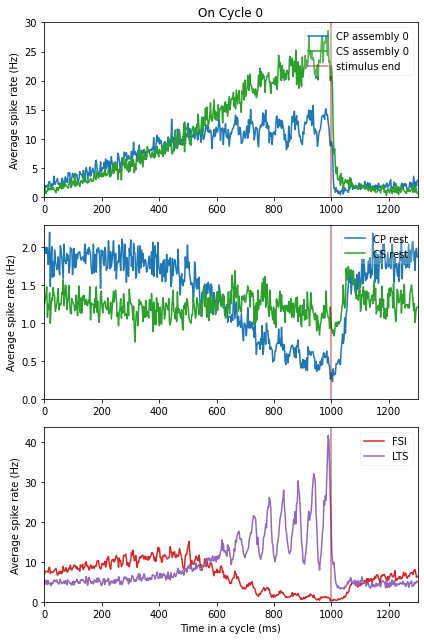

In [9]:
show_unique_cyc = 2  # maximum number of unique cycles to show
show_unique_cyc = list(cyc_to_assy.keys())[:show_unique_cyc]
show_off = int(n_unique_cycle > 1) + 1

t_cyc = pop_rspk_cyc.time
for i in show_unique_cyc:
    show_assy = cyc_to_assy[i] + ([-1] if rest_assy else [])
    n_rows = len(show_assy) + 1
    _, axs = plt.subplots(n_rows, show_off, squeeze=False,
                          figsize=(6 * show_off, 3 * n_rows))
    for j in range(show_off):
        for a, ax in zip(show_assy, axs[:-1, j]):
            da = grp_rspk_cyc_avg[j].sel(unique_cycle=i, assembly=a)
            for p in PN_pop_names:
                rspk = da.sel(population=p).values
                ax.plot(t_cyc, rspk, color=pop_color[p], label=group_names[(a, p)])
        da = pop_rspk_cyc_avg[j].sel(unique_cycle=i)
        for p in ITN_pop_names:
            rspk = da.sel(population=p).values
            axs[-1, j].plot(t_cyc, rspk, color=pop_color[p], label=p)
    for j, ax in enumerate(axs.ravel()):
        ax.axvline(on_time * 1000, color='darkred', alpha=0.5,
                   label=None if j else 'stimulus end')
        ax.set_xlim(0, 1000 * (on_time + win_extend))
        ax.set_ylim(bottom=0)
    for ax in axs[:, 0]:
        ax.set_ylabel('Average spike rate (Hz)')
        ax.legend(loc='upper right', framealpha=0.2)
    for j, ax in enumerate(axs[0, :]):
        ax.set_title(('Off' if j else 'On') + f' Cycle {i:d}')
    for ax in axs[-1, :]:
        ax.set_xlabel('Time in a cycle (ms)')
    plt.tight_layout()
plt.show()

### Population trajectory

In [10]:
filt_sigma = 20  # ms. Gaussian filter parameter for smoothing
filt_sigma = int(filt_sigma * fs / 1000)

marker_kwargs = dict(
    marker_times = np.array((t_cyc[0], 1000 * on_time, t_cyc[-1])),
    marker_names = ['stimulus on', 'stimulus off', 'cycle end'],
    marker_props = dict(
        marker = ['o', 'x', '^'],
        markeredgecolor = ['orange', 'darkred', 'g']
    )
)

#### Trajectories among PN assemblies

On Cycle 0


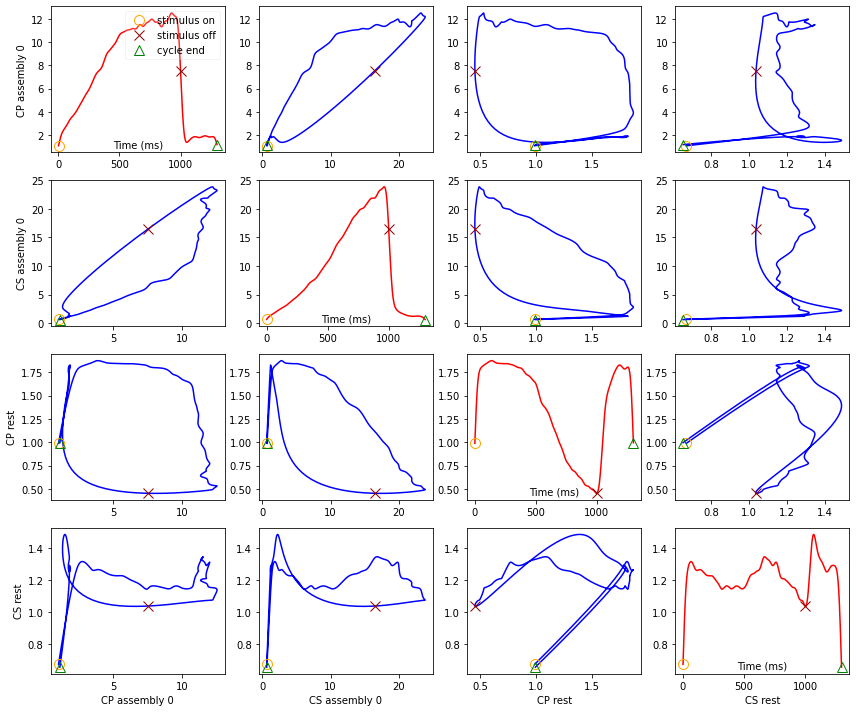

In [11]:
for i in show_unique_cyc:
    show_assy = cyc_to_assy[i] + ([-1] if rest_assy else [])
    for j in range(show_off):
        print(('Off' if j else 'On') + f' Cycle {i:d}')
        da = grp_rspk_cyc_avg[j].sel(unique_cycle=i).stack(group=('assembly', 'population'))
        rspk = {group_names[g]: da.sel(group=g) for g in group_names if g[0] in show_assy}
        rspk = {g: gaussian_filter(x, filt_sigma, mode='constant') for g, x in rspk.items()}
        axs = plot.trajectory_pairplot(rspk, time=t_cyc, **marker_kwargs)
        plt.show()

#### Trajectories on PN assemblies and ITNs

In [12]:
grp_rspk_PN = process.combine_spike_rate(grp_rspk, 'population')
PN_grp_rspk_cyc_avg = [process.average_group_windows(x)
    for x in process.group_windows(process.windowed_xarray(
        grp_rspk_PN.spike_rate, windows), win_grp_idx)]
PN_group_names = {a: 'PN' + (f' assembly {a:d}' if a >= 0 else ' rest') for a in assy_ids}

On Cycle 0


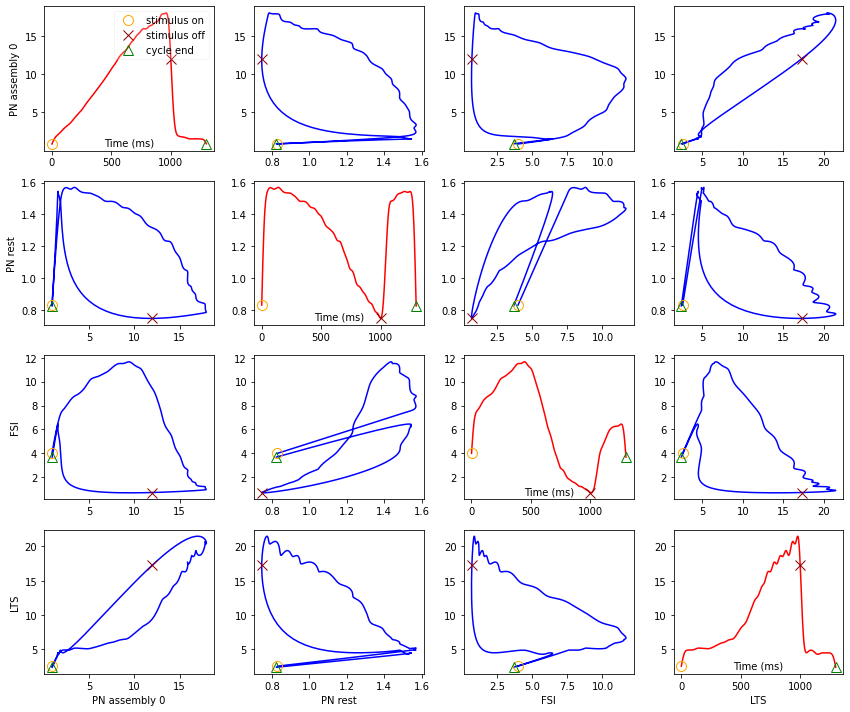

In [13]:
for i in show_unique_cyc:
    show_assy = cyc_to_assy[i] + ([-1] if rest_assy else [])
    for j in range(show_off):
        print(('Off' if j else 'On') + f' Cycle {i:d}')
        da = PN_grp_rspk_cyc_avg[j].sel(unique_cycle=i)
        rspk = {PN_group_names[a]: da.sel(assembly=a) for a in show_assy}
        da = pop_rspk_cyc_avg[j].sel(unique_cycle=i)
        rspk.update({p: da.sel(population=p) for p in ITN_pop_names})
        rspk = {g: gaussian_filter(x, filt_sigma, mode='constant') for g, x in rspk.items()}
        axs = plot.trajectory_pairplot(rspk, time=t_cyc, **marker_kwargs)
        plt.show()